<h1 style="font-size:3rem;color:#A3623B;">Lab 6</h1>

## Security and Ethical aspects of data
### Amaya Nogales Gómez

## 6.1 Fairness metrics for synthetic datasets


In [123]:
#we import all the required libraries
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # for generating synthetic data 
from sklearn import datasets #For real datasets
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

In [124]:
from sklearn.svm import SVC
from sklearn import metrics

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [125]:
def generate_synthetic_data_bias():

    """
        Code for generating the synthetic data.
        We will have two features and a binary class.
        
    """

    n_samples = 20 # generate these many data points per class
    #For biased data
    p_sen=0.2 #this parameter sets the probability of being protected (sensitive feature=1)
    delta1=[3,-2] # This is the increment of the mean for the positive class
    delta2=[3,-2] # This is the increment of the mean for the negative class
    
    
    def gen_gaussian_sensitive(size, mean_in, cov_in, class_label, sensitive):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(size)
        y = np.ones(size, dtype=int) * class_label
        x_sen = np.ones(size, dtype=float) * sensitive
        return nv,X,y,x_sen

    """ Generate the features randomly """
    #For the NON-protected group (sensitive feature=0, for ex. men)
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1, x_sen1= gen_gaussian_sensitive(int((1-p_sen)*n_samples), mu1, sigma1, 1,0) # positive class
    nv2, X2, y2, x_sen2= gen_gaussian_sensitive(int((1-p_sen)*n_samples),mu2, sigma2, 0,0) # negative class
    
    
    #For the Protected group (sensitive feature=1, for ex. women)
    # We will generate one gaussian cluster for each class
    mu3, sigma3 = np.add(mu1,delta1), [[5, 1], [1, 5]]
    mu4, sigma4 = np.add(mu2,delta2), [[10, 1], [1, 3]]
    nv3, X3, y3, x_sen3 = gen_gaussian_sensitive(int(p_sen*n_samples), mu3, sigma3, 1,1.) # positive class
    nv4, X4, y4, x_sen4 = gen_gaussian_sensitive(int(p_sen*n_samples),mu4, sigma4, 0,1.) # negative class
    

    

    # join the positive and negative class clusters
    X = np.vstack((X1, X2, X3, X4))
    y = np.hstack((y1, y2, y3, y4))
    x_prot= np.hstack((x_sen1, x_sen2, x_sen3, x_sen4))
    

    # shuffle the data
    perm = list(range(0,n_samples*2))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    x_prot=x_prot[perm]
    
    

    return X,y,x_prot

In [126]:
X_syn, y_syn, x_bias = generate_synthetic_data_bias()

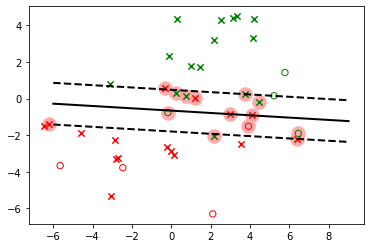

In [127]:
#plt.scatter(X_syn[y_syn==1][:, 0], X_syn[y_syn==1][:, 1], color='#378661', marker='x', s=40, linewidth=1.5, label= "Class +1")
#plt.scatter(X_syn[y_syn==0][:, 0], X_syn[y_syn==0][:, 1], color='#A73730', marker='x', s=40, linewidth=1.5, label = "Class -1")

X_s_0 = X_syn[x_bias == 0.0]
X_s_1 = X_syn[x_bias == 1.0]
y_s_0 = y_syn[x_bias == 0.0]
y_s_1 = y_syn[x_bias == 1.0]

# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(4))
svm_clf.fit(X_syn, y_syn)

plot_svc_decision_boundary(svm_clf, -6, 9)
plt.scatter(X_s_0[y_s_0==1][:, 0], X_s_0[y_s_0==1][:, 1], color='green', marker='x', s=40, linewidth=1.5, label= "Non-prot. +1")
plt.scatter(X_s_0[y_s_0==0][:, 0], X_s_0[y_s_0==0][:, 1], color='red', marker='x', s=40, linewidth=1.5, label = "Non-prot. -1")
plt.scatter(X_s_1[y_s_1==1][:, 0], X_s_1[y_s_1==1][:, 1], color='green', marker='o', facecolors='none', s=40, label = "Prot. +1")
plt.scatter(X_s_1[y_s_1==0][:, 0], X_s_1[y_s_1==0][:, 1], color='red', marker='o', facecolors='none', s=40, label = "Prot. -1")

#plt.savefig('aggre.png')
plt.show()

First we calculate the accuracy of the SVM classifier in our dataset:

In [128]:
#Accuracy
y_pred=svm_clf.predict(X_syn)

print("Accuracy: %.1f" % (metrics.accuracy_score(y_syn, y_pred)*100), "%")


Accuracy: 82.5 %


We first implement the equal opportunity metric:

## Equal Opportunity Metric

In [129]:
#Let us now implement the equal opportunity metric:
def equal_opportunity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (y[i]==1 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y[i]==1 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_EOpp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_EOpp


In [130]:
UNF_EOpp=equal_opportunity(y_syn,y_pred, x_bias)
print('UNF_EOpp = %.2f' % (UNF_EOpp*100),"%")

UNF_EOpp = 43.75 %


### Questions:


**1-** Calculate the predictive equality metric for the given dataset and classifier.

**2-** Calculate the equalized odds metric for the given dataset and classifier.

**3-** Calculate the predictive parity metric for the given dataset and classifier.

**4-** Calculate the statistical parity metric for the given dataset and classifier.

**5-** a)Calculate the disparate impact metric for the given dataset and classifier.

  b)Does this classifier satisfy the 80%-rule?
  


### Predictive Equality Metric:

In [131]:
#predictive equality metric:
def predictive_equality(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        #if (y[i]==-1 and x_prot[i]==0): ##In the dataset we produce we have 0's instead of (-1).
        if (y[i]==0 and x_prot[i]==0): #So we replace (-1)'s to 0's
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        #if (y[i]==-1 and x_prot[i]==1):
        if (y[i]==0 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_EOpp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_EOpp

In [132]:
UNF_EOpp = predictive_equality(y_syn,y_pred, x_bias)
print('Predictive Equality = %.2f' % (UNF_EOpp*100),"%")



Predictive Equality = 25.00 %


## Equalized Odds:

In [133]:
#Equalized Odds metric:
def equalized_odds(y,y_pred, x_prot):
    Pos_pro1=0.0
    Pos_nonpro1=0.0
    PPos_pro1=0.0
    PPos_nonpro1=0.0

    Pos_pro2=0.0
    Pos_nonpro2=0.0
    PPos_pro2=0.0
    PPos_nonpro2=0.0
    
    n=y_pred.size

    for i in range(0,n):
        
        if (y[i]==1 and x_prot[i]==0): 
            Pos_nonpro1=Pos_nonpro1+1
            if (y_pred[i]==1):
                PPos_nonpro1=PPos_nonpro1+1
        
        if (y[i]==1 and x_prot[i]==1):
            Pos_pro1=Pos_pro1+1
            if (y_pred[i]==1):
                PPos_pro1=PPos_pro1+1
        ####
        if (y[i]==0 and x_prot[i]==0): 
            Pos_nonpro2=Pos_nonpro2+1
            if (y_pred[i]==1):
                PPos_nonpro2=PPos_nonpro2+1
        
        if (y[i]==0 and x_prot[i]==1):
            Pos_pro2=Pos_pro2+1
            if (y_pred[i]==1):
                PPos_pro2=PPos_pro2+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_EOpp= abs((PPos_nonpro1/Pos_nonpro1)-(PPos_pro1/Pos_pro1)) + abs((PPos_nonpro2/Pos_nonpro2)-(PPos_pro2/Pos_pro2))
    
    return UNF_EOpp

In [134]:
UNF_EOpp = equalized_odds(y_syn,y_pred, x_bias)
print('equalized_odds = %.2f' % (UNF_EOpp*100),"%")



equalized_odds = 68.75 %


## Predictive Parity

In [135]:
#predictive parity metric:
def predictive_parity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (y_pred[i]==1 and x_prot[i]==0): 
            Pos_nonpro=Pos_nonpro+1
            if (y[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y_pred[i]==1 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_EOpp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_EOpp

In [136]:
UNF_EOpp = predictive_parity(y_syn,y_pred, x_bias)
print('predictive_parity = %.2f' % (UNF_EOpp*100),"%")


predictive_parity = 21.05 %


## Statistical Parity

In [137]:
#statistical_parity metric:
def statistical_parity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (x_prot[i]==0): 
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_EOpp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_EOpp

In [138]:
UNF_EOpp = statistical_parity(y_syn,y_pred, x_bias)
print('statistical_parity = %.2f' % (UNF_EOpp*100),"%")



statistical_parity = 34.38 %


## Disparate Impact

In [139]:
#disparate_impact metric:
def disparate_impact(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (x_prot[i]==0): 
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    #                       A                       B
    #UNF_EOpp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    #A-B
    UNF_EOpp=min(((PPos_pro/Pos_pro)/(PPos_nonpro/Pos_nonpro)) , ((PPos_nonpro/Pos_nonpro)/(PPos_pro/Pos_pro)))
    #min( B/A, A/B)
    
    return UNF_EOpp

In [140]:
UNF_EOpp = disparate_impact(y_syn,y_pred, x_bias)
print('disparate_impact = %.2f' % (UNF_EOpp*100),"%")


disparate_impact = 42.11 %


In [141]:
#Teacher's given results
#Predictive eq=%25
#Equalized odds=%68.8
#predictive parity= %21.1
#statistical parity=34.4
#disparate impact=42.1



#### Does this classifier satisfy the 80%-rule?

In [142]:
print("Disparate impact = ",disparate_impact(y_syn,y_pred, x_bias))
if(disparate_impact(y_syn,y_pred, x_bias) >= 0.80):
  print("This classifier satifies the 80%-rule.")
else:
  print("This classifier DOES NOT satify the 80%-rule.")

Disparate impact =  0.42105263157894735
This classifier DOES NOT satify the 80%-rule.


## 6.2 Fairness metrics for the German dataset

In [143]:
German_data=np.loadtxt('/content/German.txt')
i_prot=40 #the protected features corresponds with column 40 from the txt file
n_sample=500 # we define our training sample size
C_param=5

X_German=np.delete(German_data,[0,i_prot],1) #We eliminate the first column that correspond to labels and the protected feature

y_German=German_data[:,0] #labels
x_bias_german=German_data[:,i_prot] #protected feature

#Now let us consider a training set
X_G=X_German[1:n_sample,:]
y_G=y_German[1:n_sample]
x_bias_G=x_bias_german[1:n_sample]


# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(C_param))
svm_clf.fit(X_G, y_G)

y_pred_G=svm_clf.predict(X_G)




### Questions:
In the code before, we set i_prot=40, which means we consider the protected feature being "female divorced/separated/married". Under this choice:

**6-** Provide a table with the accuracy and the 6 fairness metrics.

**7-** Does this classifier satisfy the 80%-rule?

Now choose as protected feature being "male divorced/separated", i.e., i_prot=39. Under this choice:

**8-** Provide a table with the 6 fairness metrics.

**9-** Does this classifier satisfy the 80%-rule?

**10-** Which conclusion do you obtain comparing the tables from 6 and 8?

In [144]:
#6- Provide a table with the accuracy and the 6 fairness metrics:
#Accuracy
print("Accuracy: %.1f" % (metrics.accuracy_score(y_G, y_pred_G)*100), "%")

#
disparate_impactt = disparate_impact(y_G,y_pred_G, x_bias_G)
print('disparate_impact = %.2f' % (disparate_impactt*100),"%")

statistical_parityy = statistical_parity(y_G,y_pred_G, x_bias_G)
print('statistical_parity = %.2f' % (statistical_parityy*100),"%")

predictive_parityy = predictive_parity(y_G,y_pred_G, x_bias_G)
print('predictive_parity = %.2f' % (predictive_parityy*100),"%")

equalized_oddss = equalized_odds(y_G,y_pred_G, x_bias_G)
print('equalized_odds = %.2f' % (equalized_oddss*100),"%")


predictive_equalityy = predictive_equality(y_G,y_pred_G, x_bias_G)
print('Predictive Equality = %.2f' % (predictive_equalityy*100),"%")

equal_opportunityy=equal_opportunity(y_G,y_pred_G, x_bias_G)
print('equal_opportunity = %.2f' % (equal_opportunityy*100),"%")

from tabulate import tabulate
  
# assign data
mydata = [{"Accuracy", metrics.accuracy_score(y_G, y_pred_G)}, 
          {"Disparate impact", disparate_impactt}, 
          {"Statistical parity", statistical_parityy}, 
          {"Predictive parity", predictive_parityy}, 
          {"Equalized odds", equalized_oddss},
          {"Predictive Equality", predictive_equalityy}, 
          {"Equal opportunity", equal_opportunityy},]
  
# create header
head = [ "RESULT","METRIC"]
  
# display table
print()
print("QUESTION-6")
print("6- Provide a table with the accuracy and the 6 fairness metrics")
print(tabulate(mydata, headers=head, tablefmt="grid"))

Accuracy: 81.4 %
disparate_impact = 85.21 %
statistical_parity = 11.85 %
predictive_parity = 3.34 %
equalized_odds = 24.88 %
Predictive Equality = 20.63 %
equal_opportunity = 4.25 %

QUESTION-6
6- Provide a table with the accuracy and the 6 fairness metrics
+-----------+---------------------+
|    RESULT | METRIC              |
+===========+=====================+
| 0.813627  | Accuracy            |
+-----------+---------------------+
| 0.852146  | Disparate impact    |
+-----------+---------------------+
| 0.118545  | Statistical parity  |
+-----------+---------------------+
| 0.0333781 | Predictive parity   |
+-----------+---------------------+
| 0.248844  | Equalized odds      |
+-----------+---------------------+
| 0.206343  | Predictive Equality |
+-----------+---------------------+
| 0.0425015 | Equal opportunity   |
+-----------+---------------------+


In [145]:
print("Disparate impact = ",disparate_impact(y_G,y_pred_G, x_bias_G))
#Since the disparate impact = 85.21%:
if(disparate_impact(y_G,y_pred_G, x_bias_G) >= 0.80):
  print("This classifier satifies the 80%-rule.")
else:
  print("This classifier DOES NOT satify the 80%-rule.")

Disparate impact =  0.8521464096628544
This classifier satifies the 80%-rule.


Now choose as protected feature being "male divorced/separated", i.e., i_prot=39. Under this choice:

**8-** Provide a table with the 6 fairness metrics.

**9-** Does this classifier satisfy the 80%-rule?

**10-** Which conclusion do you obtain comparing the tables from 6 and 8?

In [146]:
#
#Now choose as protected feature being "male divorced/separated", i.e., i_prot=39. Under this choice:
#

German_data2=np.loadtxt('/content/German.txt')
i_prot=39 #the protected features corresponds with column 39 from the txt file
n_sample=500 # we define our training sample size
C_param=5

X_German2=np.delete(German_data2,[0,i_prot],1) #We eliminate the first column that correspond to labels and the protected feature

y_German2=German_data2[:,0] #labels
x_bias_german2=German_data2[:,i_prot] #protected feature

#Now let us consider a training set
X_G2=X_German2[1:n_sample,:]
y_G2=y_German2[1:n_sample]
x_bias_G2=x_bias_german2[1:n_sample]


# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(C_param))
svm_clf.fit(X_G2, y_G2)

y_pred_G2=svm_clf.predict(X_G2)

In [147]:
#8- Provide a table with the 6 fairness metrics:
#Accuracy
print("Accuracy: %.1f" % (metrics.accuracy_score(y_G2, y_pred_G2)*100), "%")

#
disparate_impactt2 = disparate_impact(y_G2,y_pred_G2, x_bias_G2)
print('disparate_impact = %.2f' % (disparate_impactt2*100),"%")

statistical_parityy2 = statistical_parity(y_G2,y_pred_G2, x_bias_G2)
print('statistical_parity = %.2f' % (statistical_parityy2*100),"%")

predictive_parityy2 = predictive_parity(y_G2,y_pred_G2, x_bias_G2)
print('predictive_parity = %.2f' % (predictive_parityy2*100),"%")

equalized_oddss2 = equalized_odds(y_G2,y_pred_G2, x_bias_G2)
print('equalized_odds = %.2f' % (equalized_oddss2*100),"%")


predictive_equalityy2 = predictive_equality(y_G2,y_pred_G2, x_bias_G2)
print('Predictive Equality = %.2f' % (predictive_equalityy2*100),"%")

equal_opportunityy2=equal_opportunity(y_G2,y_pred_G2, x_bias_G2)
print('equal_opportunity = %.2f' % (equal_opportunityy2*100),"%")

from tabulate import tabulate
  
# assign data
mydata2 = [{"Accuracy", metrics.accuracy_score(y_G2, y_pred_G2)}, 
          {"Disparate impact", disparate_impactt2}, 
          {"Statistical parity", statistical_parityy2}, 
          {"Predictive parity", predictive_parityy2}, 
          {"Equalized odds", equalized_oddss2},
          {"Predictive Equality", predictive_equalityy2}, 
          {"Equal opportunity", equal_opportunityy2},]
  
# create header
head2 = [ "RESULT","METRIC"]

print()
print("QUESTION-8")
print("8- Provide a table with the 6 fairness metrics.")
print(tabulate(mydata2, headers=head2, tablefmt="grid"))
# display table


Accuracy: 81.2 %
disparate_impact = 99.04 %
statistical_parity = 0.73 %
predictive_parity = 11.72 %
equalized_odds = 15.50 %
Predictive Equality = 13.37 %
equal_opportunity = 2.13 %

QUESTION-8
8- Provide a table with the 6 fairness metrics.
+------------+---------------------+
|     RESULT | METRIC              |
+============+=====================+
| 0.811623   | Accuracy            |
+------------+---------------------+
| 0.990421   | Disparate impact    |
+------------+---------------------+
| 0.00733676 | Statistical parity  |
+------------+---------------------+
| 0.117172   | Predictive parity   |
+------------+---------------------+
| 0.154981   | Equalized odds      |
+------------+---------------------+
| 0.13369    | Predictive Equality |
+------------+---------------------+
| 0.0212908  | Equal opportunity   |
+------------+---------------------+


In [148]:
#9- Does this classifier satisfy the 80%-rule?
#
print("Disparate impact = ",disparate_impact(y_G2,y_pred_G2, x_bias_G2))
#Since the disparate impact = 0.99%:
if(disparate_impact(y_G2,y_pred_G2, x_bias_G2) >= 0.80):
  print("This classifier satifies the 80%-rule ")
else:
  print("This classifier DOES NOT satify the 80%-rule.")


Disparate impact =  0.9904214559386972
This classifier satifies the 80%-rule 


### 10- Which conclusion do you obtain comparing the tables from 6 and 8?

 The 80% rule was created to help companies determine if they have been unwittingly discriminatory in their hiring process. The rule states that companies should be hiring protected groups at a rate that is at least 80% of that of white men. So, if this dataset belongs to a company, they satisfy the 80%-rule for 

The disparate impact is higher when we protect men. That means according to dataset, the "female divorced/separated/married" is not discriminated because disparate impact is 85.21 %. However, when we look at disparate impact in "male divorced/separated" the dispare impact is 99%. That means the dataset is consists of more males than female and males are positive discriminated.

<h2> 6.3 The COMPAS dataset. What happens if we change the choice of variables?</h2> 

Let's take our own decisions:

In [149]:
# filter dplyr warnings
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [150]:
%%R
library(dplyr)
#You can choose your favorite option:
#a)Download the dataset and access it locally
#raw_data <- read.csv("./compas-scores-two-years.csv") 
#b)Access the dataset directly from the repository
raw_data <- read.csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")
nrow(raw_data)
colnames(raw_data)

 [1] "id"                      "name"                   
 [3] "first"                   "last"                   
 [5] "compas_screening_date"   "sex"                    
 [7] "dob"                     "age"                    
 [9] "age_cat"                 "race"                   
[11] "juv_fel_count"           "decile_score"           
[13] "juv_misd_count"          "juv_other_count"        
[15] "priors_count"            "days_b_screening_arrest"
[17] "c_jail_in"               "c_jail_out"             
[19] "c_case_number"           "c_offense_date"         
[21] "c_arrest_date"           "c_days_from_compas"     
[23] "c_charge_degree"         "c_charge_desc"          
[25] "is_recid"                "r_case_number"          
[27] "r_charge_degree"         "r_days_from_arrest"     
[29] "r_offense_date"          "r_charge_desc"          
[31] "r_jail_in"               "r_jail_out"             
[33] "violent_recid"           "is_violent_recid"       
[35] "vr_case_number"          

Note: if you obtain the following error: "UsageError: Cell magic `%%R` not found."
Try this solution: pip install rpy2


## Filtering of data

<em>In a 2009 study examining the predictive power of its COMPAS score, Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored.

It was not always clear, however, which criminal case was associated with an individual’s COMPAS score. To match COMPAS scores with accompanying cases, we considered cases with arrest dates or charge dates within 30 days of a COMPAS assessment being conducted. In some instances, we could not find any corresponding charges to COMPAS scores. We removed those cases from our analysis.

Next, we sought to determine if a person had been charged with a new crime subsequent to crime for which they were COMPAS screened. We did not count traffic tickets and some municipal ordinance violations as recidivism. We did not count as recidivists people who were arrested for failing to appear at their court hearings, or people who were later charged with a crime that occurred prior to their COMPAS screening.</em>

We do the same filtering that in the Propublica Study **BUT** we select different variables.

Finally we save the filtered csv file.



In [151]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out,
                    juv_fel_count,juv_misd_count,juv_other_count,is_violent_recid) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(is_violent_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
write.csv(df,"propublica_ext.csv")

nrow(df)

[1] 6172


Now we import the same libraries as in the previous labs.

In [152]:
#we import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # for generating synthetic data 
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

We first read the filtered data. 

In [153]:
df = pd.read_csv("propublica_ext.csv")

print("Size of the dataset: %d" % len(df.index)) #We calculate the number of objects in the dataset




Size of the dataset: 6172


In [154]:
for col in df:
    print(df[col].unique())

[   1    2    3 ... 6170 6171 6172]
[69 34 24 44 41 43 39 27 23 37 47 31 25 64 21 32 26 33 30 55 49 29 51 35
 28 53 38 22 62 56 45 40 50 20 36 54 19 42 52 59 61 63 48 46 58 78 57 66
 70 60 65 68 71 83 67 75 72 74 96 73 80 77 76 79 18]
['F' 'M']
['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']
['Greater than 45' '25 - 45' 'Less than 25']
['Low' 'Medium' 'High']
['Male' 'Female']
[ 0  4 14  3  1  7  6  5 13  8  9 21  2 15 10 28 19 11 23 25 36 12 20 33
 16 18 17 22 30 24 27 26 37 29 31 38]
[ -1   0 -20  22  -2 -24 -13 -15 -10 -30  -4 -16 -26  -7  29  -3  23 -11
 -22 -21 -12  -8  -5 -23 -14  -9  -6 -27 -19 -18  26 -29  28   7 -17 -28
   9 -25  13  20  17  30   6   2  16   8   1  18  15  21  27  11   3  14
   5  24]
[ 1  3  4  6 10  5  9  2  7  8]
[0 1]
[0 1]
['2013-08-13 06:03:42' '2013-01-26 03:45:27' '2013-04-13 04:58:34' ...
 '2014-01-13 05:48:01' '2014-03-08 08:06:02' '2014-06-28 12:16:41']
['2013-08-14 05:41:20' '2013-02-05 05:36:53' '2013-04-14 07:02:04'

We need to binarize all the categorical features we considered in the dataset:

In [155]:
df = (
    pd.read_csv("propublica_ext.csv")
    #We first binarize the categorical feature c_charge_degree
    .assign(c_charge=lambda x:x['c_charge_degree'].replace({'F': 1, 'M':0}))
    #race
    .assign(african_american=lambda x:x['race'].replace({'Other': 0, 'African-American': 1, 'Caucasian': 0, 'Hispanic': 0, 'Asian': 0,'Native American': 0}))
    .assign(caucasian=lambda x:x['race'].replace({'Other': 0, 'African-American': 0, 'Caucasian': 1, 'Hispanic': 0, 'Asian': 0,'Native American': 0}))
    .assign(native_american=lambda x:x['race'].replace({'Other': 0, 'African-American': 0, 'Caucasian': 0, 'Hispanic': 0, 'Asian': 0,'Native American': 1}))
    .assign(hispanic=lambda x:x['race'].replace({'Other': 0, 'African-American': 0, 'Caucasian': 0, 'Hispanic': 1, 'Asian': 0,'Native American': 0}))
    .assign(asian=lambda x:x['race'].replace({'Other': 0, 'African-American': 0, 'Caucasian': 0, 'Hispanic': 0, 'Asian': 1,'Native American': 0}))
    .assign(other=lambda x:x['race'].replace({'Other': 1, 'African-American': 0, 'Caucasian': 0, 'Hispanic': 0, 'Asian': 0,'Native American': 0}))
    #age_cat
    .assign(less_than_25=lambda x:x['age_cat'].replace({'Greater than 45':0, '25 - 45':0, 'Less than 25':1}))
    .assign(between_25_45=lambda x:x['age_cat'].replace({'Greater than 45':0, '25 - 45':1, 'Less than 25':0}))
    .assign(greater_than_25=lambda x:x['age_cat'].replace({'Greater than 45':1, '25 - 45':0, 'Less than 25':0}))
    #score_text
    .assign(score_low=lambda x:x['score_text'].replace({'Low':1, 'Medium':0, 'High':0}))
    .assign(score_medium=lambda x:x['score_text'].replace({'Low':0, 'Medium':1, 'High':0}))
    .assign(score_high=lambda x:x['score_text'].replace({'Low':0, 'Medium':0, 'High':1}))
    #sex
    .assign(Male=lambda x:x['sex'].replace({'Male': 1, 'Female':0}))
    
)
DeleteList=['c_charge_degree','race','age_cat','score_text','sex','c_jail_in','c_jail_out']
df=df.drop(DeleteList, axis=1)
print("Dataset with %d" % df.shape[0],"objects and %d" % df.shape[1], "variables") #We calculate the number of objects in the dataset

df.head()


Dataset with 6172 objects and 25 variables


,Unnamed: 0,age,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count,is_violent_recid,c_charge,african_american,caucasian,native_american,hispanic,asian,other,less_than_25,between_25_45,greater_than_25,score_low,score_medium,score_high,Male
0,1,69,0,-1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1
1,2,34,0,-1,3,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,1
2,3,24,4,-1,4,1,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1
3,4,44,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1
4,5,41,14,-1,6,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1


Actually, our dataset is only composed of 23 variables, since we do not include the first column as variable, and the variable "two_year_recid" is the binary label to predict.

We then define our data and our label:


In [156]:
display(df.columns)

Index(['Unnamed: 0', 'age', 'priors_count', 'days_b_screening_arrest',
       'decile_score', 'is_recid', 'two_year_recid', 'juv_fel_count',
       'juv_misd_count', 'juv_other_count', 'is_violent_recid', 'c_charge',
       'african_american', 'caucasian', 'native_american', 'hispanic', 'asian',
       'other', 'less_than_25', 'between_25_45', 'greater_than_25',
       'score_low', 'score_medium', 'score_high', 'Male'],
      dtype='object')

We now select from this list only the variables we want to consider in our classification problem and the corresponding labels:

In [157]:
# Here is a way to select these columns using the column names
    
#feature_columns = ['Number_of_Priors', 'score_factor','Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American','Asian', 'Hispanic', 'Native_American', 'Other', 'Female',       'Misdemeanor']

feature_columns = ['age', 'priors_count', 'days_b_screening_arrest',
         'juv_fel_count',
       'juv_misd_count', 'juv_other_count', 'is_violent_recid', 'c_charge',
        'less_than_25', 'between_25_45', 'greater_than_25',
        'Male']


data = df[feature_columns].values
y = df['two_year_recid'].values
df=df.assign(COMPAS_Decision=lambda x:x['score_low'].replace({0: 1, 1:0}))
y_compas = df['COMPAS_Decision'].values

In [158]:
#We load the libraries for the SVM

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# shuffle the data
#n_samples=data.shape[0]
#perm = list(range(0,n_samples))
#shuffle(perm)
#data = data[perm]
#y = y[perm]
#y_compas=y_compas[perm]


#Create train and validation set
#train_x, test_x, train_y, test_y = train_test_split(data, y, test_size=0.1, shuffle=True, stratify=y, random_state=42)

svm_clf = SVC(kernel="linear", C=1.0)
svm_clf.fit(data, y)

y_pred=svm_clf.predict(data)





In [159]:

disparate_impact_SVM = disparate_impact(y,y_pred, df['african_american'])
print('disparate_impact = %.2f' % (disparate_impact_SVM*100),"%")


disparate_impact = 51.55 %


In [160]:
b_recid = df[df['african_american'] == 1]
w_recid = df[df['caucasian'] == 1]
print(
    ' Accuracy SVM (All):  \t %.2f' % (metrics.accuracy_score(y, y_pred)*100), "%\n",
    'Accuracy SVM (Black):\t %.2f' % (metrics.accuracy_score(y_pred[df['african_american'] == 1], 
                                                             b_recid['two_year_recid'])*100),"%\n", 
    'Accuracy SVM (White):\t %.2f' % (metrics.accuracy_score(y_pred[df['caucasian'] == 1],
                                                             w_recid['two_year_recid'])*100),"%\n",

)

print(pd.crosstab(y_pred, df['two_year_recid'], rownames=['Predicted recividism'],
            colnames=['Actual recividism'],normalize='columns'))
print()

FPR_s=pd.crosstab(y_pred, df['two_year_recid'], rownames=['Predicted recividism'],
                  colnames=['Actual recividism'],normalize='columns')[0][1]
FNR_s=pd.crosstab(y_pred, df['two_year_recid'], rownames=['Predicted recividism'],
                  colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')

print("FPR SVM %.2f" % (FPR_s*100),"%")
print("FNR SVM %.2f" % (FNR_s*100),"%")




 Accuracy SVM (All):  	 70.01 %
 Accuracy SVM (Black):	 68.57 %
 Accuracy SVM (White):	 71.18 %

Actual recividism            0         1
Predicted recividism                    
0                     0.903955  0.543966
1                     0.096045  0.456034

FPR SVM 9.60 %
FNR SVM 54.40 %


## Questions:

**11-** Provide the accuracy for the COMPAS dataset.

**12-** Provide the accuracy for black defendants for the COMPAS dataset.

**13-** Provide the accuracy for white defendants for the COMPAS dataset.

**14-** Provide the FPR for the COMPAS dataset.

**15-** Provide the FNR for the COMPAS dataset.



In [161]:
#11- Provide the accuracy for the COMPAS dataset:
#12- Provide the accuracy for black defendants for the COMPAS dataset:
#13- Provide the accuracy for white defendants for the COMPAS dataset:
#14- Provide the FPR for the COMPAS dataset:
#15- Provide the FNR for the COMPAS dataset:

b_recid = df[df['african_american'] == 1]
w_recid = df[df['caucasian'] == 1]
print(
    ' Accuracy Compas (All):  \t %.2f' % (metrics.accuracy_score(y,y_compas)*100), "%\n",
    'Accuracy Compas (Black):\t %.2f' % (metrics.accuracy_score(y[df['african_american'] == 1],
                                                             b_recid['COMPAS_Decision'])*100),"%\n", 
    'Accuracy Compas (White):\t %.2f' % (metrics.accuracy_score(y[df['caucasian'] == 1],
                                                             w_recid['COMPAS_Decision'])*100),"%\n",

)



FPR_compas=pd.crosstab(df['COMPAS_Decision'], df['two_year_recid'], rownames=['Predicted recividism'],
                         colnames=['Actual recividism'],normalize='columns')[0][1]
FNR_compas=pd.crosstab(df['COMPAS_Decision'], df['two_year_recid'], rownames=['Predicted recividism'],
                         colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')

print("FPR Compas COMPASS %.2f" % (FPR_compas*100),"%")
print("FNR Compas COMPASS %.2f" % (FNR_compas*100),"%")

 Accuracy Compas (All):  	 66.07 %
 Accuracy Compas (Black):	 64.91 %
 Accuracy Compas (White):	 67.19 %

FPR Compas COMPASS 30.27 %
FNR Compas COMPASS 38.31 %


In [162]:
#(given)
#For the COMPAS: 
FPR_b_comp=pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],
                  normalize='columns')[0][1]
FNR_b_comp=pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], 
                  rownames=['Predicted recividism'],colnames=['Actual recividism'],
                  normalize='columns')[1][0].astype('float')

print("FPR of Black %.2f" % (FPR_b_comp*100),"%")
print("FNR of Black %.2f" % (FNR_b_comp*100),"%")



FPR of Black 42.34 %
FNR of Black 28.48 %


## Questions:

For the COMPAS classifier:

**16-** Calculate the FPR for white defendants.

**17-** Calculate the FNR for white defendants.

**18-** Replace **x** by the right number in the two following statement:

"FPR of Black is **x** times greater than for White"

**19-** Replace **x** by the right number in the two following statement:

"FNR of Black is **x** times smaller than for White"



In [163]:
#16- Calculate the FPR for white defendants:
#17- Calculate the FNR for white defendants:
b_recid = df[df['african_american'] == 1]
w_recid = df[df['caucasian'] == 1]


#For the COMPAS: 
FPR_w_comp=pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],
                  normalize='columns')[0][1]
FNR_w_comp=pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], 
                  rownames=['Predicted recividism'],colnames=['Actual recividism'],
                  normalize='columns')[1][0].astype('float')

print("FPR for white defendants %.2f" % (FPR_w_comp*100),"%")
print("FNR for white defendants %.2f" % (FNR_w_comp*100),"%")

FPR for white defendants 22.01 %
FNR for white defendants 49.64 %


In [164]:
#18- Replace x by the right number in the two following statement:
#"FPR of Black is x times greater than for White":
print("FPR of Black is", FPR_b_comp/FPR_w_comp ," times greater than for White")

#19- Replace x by the right number in the two following statement:
#"FNR of Black is x times smaller than for White":
print("FNR of Black is", FNR_w_comp/FNR_b_comp," times smaller than for White")

FPR of Black is 1.9232342111919953  times greater than for White
FNR of Black is 1.7429977932439313  times smaller than for White


In [165]:
#(given)
#For the SVM:
FPR_b_svm=pd.crosstab(y_pred[df['african_american'] == 1], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]
FNR_b_svm=pd.crosstab(y_pred[df['african_american'] == 1], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')

print("FPR of Black %.2f" % (FPR_b_svm*100),"%")
print("FNR of Black %.2f" % (FNR_b_svm*100),"%")

FPR of Black 13.74 %
FNR of Black 47.56 %


## Questions:

For the SVM classifier:

**20-** Calculate the FPR for white defendants.

**21-** Calculate the FNR for white defendants.

**22-** Replace **x** by the right number in the two following statement:

"FPR of Black is **x** times greater than for White"

**23-** Replace **x** by the right number in the two following statement:

"FNR of Black is **x** times smaller than for White"

In [166]:
#20- Calculate the FPR for white defendants.
#21- Calculate the FNR for white defendants.
b_recid = df[df['african_american'] == 1]
w_recid = df[df['caucasian'] == 1]


#For the SVM: 
FPR_w_svm=pd.crosstab(y_pred[df['caucasian'] == 1], w_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]
FNR_w_svm=pd.crosstab(y_pred[df['caucasian'] == 1], w_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')


print("FPR for white defendants %.2f" % (FPR_w_svm*100),"%")
print("FNR for white defendants %.2f" % (FNR_w_svm*100),"%")

FPR for white defendants 6.48 %
FNR for white defendants 63.63 %


In [167]:
#(given)
#For the SVM:
FPR_b_svm=pd.crosstab(y_pred[df['african_american'] == 1], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]
FNR_b_svm=pd.crosstab(y_pred[df['african_american'] == 1], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')

print("FPR of Black %.2f" % (FPR_b_svm*100),"%")
print("FNR of Black %.2f" % (FNR_b_svm*100),"%")

FPR of Black 13.74 %
FNR of Black 47.56 %


In [168]:
#22- Replace x by the right number in the two following statement:
#"FPR of Black is x times greater than for White"
print("FPR of Black is", FPR_b_svm/FPR_w_svm, " times greater than for White")
#23- Replace x by the right number in the two following statement:
#"FNR of Black is x times smaller than for White"
print("FNR of Black is", FNR_w_svm/ FNR_b_svm ," times smaller than for White")

FPR of Black is 2.1203546020276614  times greater than for White
FNR of Black is 1.3377421540546366  times smaller than for White


## Questions: 

**24-** Fill in the following table:

**25-** Which is the best solution in terms of accuracy? Is it fair (in terms of accuracy)?

**26-** Which is the best solution in terms of FPR? Based on answers 18 and 22, which solution is more fair (in terms of FPR)?

**27-** Which is the best solution in terms of FNR? Based on answers 19 and 23, which solution is more fair (in terms of FNR)?

**28-** Calculate the 6 fairness metrics for the COMPAS classifier.

**29-** Calculate the 6 fairness metrics for the SVM classifier.

**30-** As a future (or actual) data scientist, which solution would you choose for **this** specific problem? Justify your answer.

$$
\begin{array}{cc}
& \text{SVM }&\text{COMPAS }\\
&\begin{array}{cccc}
\hline \hline 
&\text { All } & \text { Black } & \text { White }\\
\hline 
\text{Accuracy}& 70.01& 68.57 &71.18  \\
\text{FPR}&9.60 & 13.74 & 6.48 \\
\text{FNR}& 54.40& 45.56 & 63.63 \\
\hline
\end{array}
&\begin{array}{cccc}
\hline \hline 
&\text { All } & \text { Black } & \text { White }\\
\hline 
\text{Accuracy}&66.07 & 64.91 & 67.19 \\
\text{FPR}& 30.27& 42.34 & 22.01 \\
\text{FNR}& 38.31& 28.48 & 49.64 \\
\hline
\end{array}\\
\end{array}
$$


### 25- Which is the best solution in terms of accuracy? Is it fair (in terms of accuracy)?

In terms of overall accuracy, SVM has a better solution because its accuracy result is higher(0.70) than COMPAS overall accuracy(0.66). 
We can say that it SVM solution is kinda fair solution in term of accuracy because its black-accuracy is 0.685 and white-accuracy is 0.711 which are close to each other. If the difference between them would be high, we cannot say that it is a fair solution in terms of accuracy.

### 26- Which is the best solution in terms of FPR? Based on answers 18 and 22, which solution is more fair (in terms of FPR)?
FPR means that it is predicted as class 1(s/he will have a crime), however in reality s/he didn't not have a crime. So, it predicted people as quilty although they are innocent.

- Answer-18 COMPASS: FPR of Black is 1.9232342111919953  times greater than for White

- Answer-22 SVM: FPR of Black is 2.1203546020276614  times greater than for White

- The best solution in terms of FPR is SVM solution because its overall FPR is 9.60 and its is lower than COMPAS overall FPR (30.27). Lower FPR is good for fairness. 

- Based on answers 18 and 22, the COMPASS solution is more fair because FPR of black is 1.92 times greater than white. However, in SVM FPR of Black is 2.12 times greater than white. Since 1.92 < 2.12, COMPAS fairness is better than SVM fairness according to FPR rates of black and white.

### 27- Which is the best solution in terms of FNR? Based on answers 19 and 23, which solution is more fair (in terms of FNR)?

FNR means that the algorithm predicted people as innocent(they will not have a crime in future). However in real life, they had a crime(they are quilty).

- Answer 19-COMPASS: FNR of Black is 1.7429977932439313  times smaller than for White

- Answer 22-SVM: FNR of Black is 1.3377421540546366  times smaller than for White

- In terms of FNR, the best solution is COMPAS because its overall FNR is 38.31 smaller than the SVM overall FNR (54.40). Lower FNR is better to correctly classfy people.

- Based on answers 19 and 22, SVM solution is more fair. Let me explain this. If the white-FNR is greater than black-FNR, that means the algorithm positive-discriminate whites because the algorithm detects them innocent although they are not. So, In a fair algorithm the white-FNR should NOT be bigger than black-FNR.
- According to explanation, SVM solution is more fair since FNR-black is more smaller than FNR-white (1.33) compared to Compass solution(1.74).

In [169]:
#28- Calculate the 6 fairness metrics for the COMPAS classifier:
#
#I choosed the "african_american" column as protected group
disparate_impact_compas = disparate_impact(y,y_compas, df['african_american'])
print('disparate_impact_compas = %.2f' % (disparate_impact_compas*100),"%")

statistical_parity_compas = statistical_parity(y,y_compas, df['african_american'])
print('statistical_parity_compas = %.2f' % (statistical_parity_compas*100),"%")

predictive_parity_compas = predictive_parity(y,y_compas, df['african_american'])
print('predictive_parity_compas = %.2f' % (predictive_parity_compas*100),"%")

equalized_odds_compas = equalized_odds(y,y_compas, df['african_american'])
print('equalized_odds_compas = %.2f' % (equalized_odds_compas*100),"%")


predictive_equality_compas = predictive_equality(y,y_compas, df['african_american'])
print('Predictive Equality_compas = %.2f' % (predictive_equality_compas*100),"%")

equal_opportunity_compas=equal_opportunity(y,y_compas, df['african_american'])
print('equal_opportunity_compas = %.2f' % (equal_opportunity_compas*100),"%")

from tabulate import tabulate
  
# assign data
mydata3 = [ 
          {"Disparate impact", disparate_impact_compas}, 
          {"Statistical parity", statistical_parity_compas}, 
          {"Predictive parity", predictive_parity_compas}, 
          {"Equalized odds", equalized_odds_compas},
          {"Predictive Equality", predictive_equality_compas}, 
          {"Equal opportunity", equal_opportunity_compas},]
  
# create header
head3 = [ "RESULT","METRIC"]

print()
print("QUESTION-28")
print("#28- Calculate the 6 fairness metrics for the COMPAS classifier:")
print(tabulate(mydata3, headers=head3, tablefmt="grid"))
# display table

disparate_impact_compas = 53.40 %
statistical_parity_compas = 26.84 %
predictive_parity_compas = 5.84 %
equalized_odds_compas = 46.00 %
Predictive Equality_compas = 21.95 %
equal_opportunity_compas = 24.05 %

QUESTION-28
#28- Calculate the 6 fairness metrics for the COMPAS classifier:
+----------+---------------------+
|   RESULT | METRIC              |
+==========+=====================+
| 0.534041 | Disparate impact    |
+----------+---------------------+
| 0.268422 | Statistical parity  |
+----------+---------------------+
| 0.058429 | Predictive parity   |
+----------+---------------------+
| 0.459981 | Equalized odds      |
+----------+---------------------+
| 0.219488 | Predictive Equality |
+----------+---------------------+
| 0.240493 | Equal opportunity   |
+----------+---------------------+


In [170]:
#29- Calculate the 6 fairness metrics for the SVM classifier.
#
#I choosed the "african_american" column as protected group

disparate_impact_SVM = disparate_impact(y,y_pred, df['african_american'])
print('disparate_impact = %.2f' % (disparate_impact_SVM*100),"%")

####
disparate_impact_SVM = disparate_impact(y,y_pred, df['african_american'])
print('disparate_impact_SVM = %.2f' % (disparate_impact_SVM*100),"%")

statistical_parity_SVM = statistical_parity(y,y_pred, df['african_american'])
print('statistical_parity_SVM = %.2f' % (statistical_parity_SVM*100),"%")

predictive_parity_SVM = predictive_parity(y,y_pred, df['african_american'])
print('predictive_parity_SVM = %.2f' % (predictive_parity_SVM*100),"%")

equalized_odds_SVM = equalized_odds(y,y_pred, df['african_american'])
print('equalized_odds_SVM = %.2f' % (equalized_odds_SVM*100),"%")


predictive_equality_SVM = predictive_equality(y,y_pred, df['african_american'])
print('Predictive Equality_SVM = %.2f' % (predictive_equality_SVM*100),"%")

equal_opportunity_SVM=equal_opportunity(y,y_pred, df['african_american'])
print('equal_opportunity_SVM = %.2f' % (equal_opportunity_SVM*100),"%")

from tabulate import tabulate
  
# assign data
mydata4 = [ 
          {"Disparate impact", disparate_impact_SVM}, 
          {"Statistical parity", statistical_parity_SVM}, 
          {"Predictive parity", predictive_parity_SVM}, 
          {"Equalized odds", equalized_odds_SVM},
          {"Predictive Equality", predictive_equality_SVM}, 
          {"Equal opportunity", equal_opportunity_SVM},]
  
# create header
head4 = [ "RESULT","METRIC"]

print()
print("QUESTION-29")
print("#29- Calculate the 6 fairness metrics for the SVM classifier:")
print(tabulate(mydata4, headers=head4, tablefmt="grid"))
# display table

disparate_impact = 51.55 %
disparate_impact_SVM = 51.55 %
statistical_parity_SVM = 16.47 %
predictive_parity_SVM = 2.63 %
equalized_odds_SVM = 24.24 %
Predictive Equality_SVM = 7.52 %
equal_opportunity_SVM = 16.72 %

QUESTION-29
#29- Calculate the 6 fairness metrics for the SVM classifier:
+-----------+---------------------+
|    RESULT | METRIC              |
+===========+=====================+
| 0.51546   | Disparate impact    |
+-----------+---------------------+
| 0.164667  | Statistical parity  |
+-----------+---------------------+
| 0.0262765 | Predictive parity   |
+-----------+---------------------+
| 0.242429  | Equalized odds      |
+-----------+---------------------+
| 0.0751886 | Predictive Equality |
+-----------+---------------------+
| 0.16724   | Equal opportunity   |
+-----------+---------------------+


$$
\begin{array}{cc}
& \text{SVM }&\text{COMPAS }\\
&\begin{array}{cccc}
\hline \hline 
&\text { All } & \text { Black } & \text { White }\\
\hline 
\text{Accuracy}& 70.01& 68.57 &71.18  \\
\text{FPR}&9.60 & 13.74 & 6.48 \\
\text{FNR}& 54.40& 45.56 & 63.63 \\
\hline
\end{array}
&\begin{array}{cccc}
\hline \hline 
&\text { All } & \text { Black } & \text { White }\\
\hline 
\text{Accuracy}&66.07 & 64.91 & 67.19 \\
\text{FPR}& 30.27& 42.34 & 22.01 \\
\text{FNR}& 38.31& 28.48 & 49.64 \\
\hline
\end{array}\\
\end{array}
$$



### 30- As a future (or actual) data scientist, which solution would you choose for this specific problem? Justify your answer.

- To choose a solution, first I will look at the disparate impact to decide whether it satifies 80% rule. The disparate mpact is 0.515 in SVM and 0.534 in Compass. They are very close to each other and not close to 80%. 

- If I consider overall FPR, SVM seems better(9.60) because it is less than COMPAS(30.27). And also black-FPR and white-FPR is lesser in SVM.

- If I consider FNR, I prefer FNR to be high in black, lower in white. If the FNR wolud be high in white that means the algorithm protects whites and predict them as innocent although they are quilty. According to question-27,  SVM solution is more fair since FNR-black is more smaller than FNR-white (1.33) compared to Compass solution(1.74).

- So, at the end I will choose SVM.